# Project 2: implementing and comparing parallel sorting algorithms

40 points + 4 possible extra credit

## Team name: tortiseshell

**Collaboration statement / resources consulted:**

## Instructions

### Motivation

In lectures we compare bitonic sort and sample sort.  In this programming project you will implement both methods in julia and MPI and compare the theoretical predictions about their performance to your measurements.

### Teams

Teams of at most three students.

### Acceptable behavior

- Discussion with other teams is encouraged (see **collaboration statement**)
- Consulting other implementations of these algorithms is expected (see **resources consulted**)
- Regardless **you should write the code for yourself.**  Like any other skill, it takes practice.  Code lifted verbatim from an outside source will be considered an honor code violation.

### Submission

**We can't run MPI.jl in a jupyter notebook.** So this assignment is a tarball of files:

- julia source code files that you will edit
- this notebook that you will edit for the reporting component at the end
- `runmain.pbs` a job submission script for getting timings on `coc-ice`

Modify your files, save as a tarball, and submit on canvas **before class April 6**.

## Steps

Steps are annotated with budgets.  "Budget: 1 day" doesn't mean it should take all day, but that if you devote some time over 10 days to the project, this is approximately how much of that time should be spent on each step. 

## 0. Get `MPI.jl` (4 pts; budget: 1 day)

- You can get it on your laptop like any other julia package `using Pkg; Pkg.add("MPI")` (make sure you have the course module loaded:

```bash
module use /storage/home/hcocice1/tisaac3/opt/pace-ice/modulefiles/
module load cx4220
```
 
- On `coc-ice`, you should do the same thing (it may take a *long* time when it looks like julia is updating a registry and not doing anything: let it run).
- We want julia to use the PACE installed MPI, so run the following on `coc-ice`:

```bash
julia --project -e 'ENV["JULIA_MPI_BINARY"]="system"; using Pkg; Pkg.build("MPI"; verbose=true)'
```

Consult https://juliaparallel.github.io/MPI.jl/stable/configuration/ (or perusall or office hours) for additional help.

- Write your code on your laptop; run it on `coc-ice` when you think it is correct.

## 1. Implement the necessary functions (24 pts; budget: 6 days)

There is one module file for each of the following functions:

1. **Check.issorted()** in `check.jl` (1 short function; 4 pts; budget 1 day)
2. **Bitonic.sort()** in `bitonic.jl` (3 short functions; 8 pts; budget 2 days)
3. **Sample.sort()** in `sample.jl` (1 more complex function; 12 pts; budget 3 days)

There are instructions at the top of each function walking you through the necessary steps.

As it says at the top, writing code is an important thing to practice.  Aim for each team member to contribute at least one of the functions in the above files.

The existing code in `main.jl` uses your `Check.issorted()` function to test if the outputs of `Bitonic.sort()` and `Sample.sort()` really do sort their inputs as they say.  You can test this correctness on your laptop (most laptops can handle, for example, `mpirun -np 8 julia ./main.jl`.

**Well commented code is eligible for partial credit.**

## 2. Measure performance on `coc-ice` (8 pts; budget: 2 days)

Use the `runmain.pbs` batch script included in your tarball like

```bash
qsub -d $PWD runmain.pbs
```

What kind of performance should you measure?  That is up to you.  You should **modify main.jl** to include additional calls to `Bitonic.sort()` and `Sample.sort()` to measure the effect of the following two factors on their performance:

1. Array size, and
2. How "random" the array initially is: uniformly random [the default of `rand`]? already sorted? adversarial (designed to maximize the network traffic)? these are just some ideas, you don't have to use them all and you could use some of your own.

**Save your measurements as graphs.**  Remember/review the best practices from "visualizing performance" earlier in the semester.

- The quantity with real units that is useful for judging absolute performance is **keys sorted per second**.
- It would be good to get some measurements of the serial algorithm `Base.sort!()` as a baseline for judging relative performance.

## 3. Summarize performance at the bottom of this notebook (4 pts; budget: 1 day)

Add your graphs as attachments to this notebook (you can also add them to the submission tarball if you'd like), and summarize what you measured.  You should compare the performance that you measured to the predictions of the performance models of bitonic sort and sample sort that appear in the notes and lectures.  (Is there a choice of $\tau$ and $\mu$ that matches your measurements?  Is sample sort eventually faster for large arrays as the theory predicts?)

## Extra credit. Bitonic sort for non-power-of-2 functions (4 pts)

Bitonic sort as described in class is limited to $p=2^k$ for some $k$.

This [tutorial](https://www.inf.hs-flensburg.de/lang/algorithmen/sortieren/bitonic/oddn.htm) describes how it can be generalized to arbitrary $p$.  If you implement a `Bitonic.sort()` that works for arbitrary $p$ and demonstrate that by measuring performance for $p=1,\dots,24$ on a `coc-ice` node, you can receive up to 4 points of extra credit.

In [2]:
using Plots

### Note: Notebook needs to be run for computational plots to be shown

Here we examine how increasing array sizes affect sorting time. Initially, as expected for smaller arrays, serial sorting algorithms out perform both Bitonic and Sample Sort, with Bitonic sort marginally outperforming Sample sort. As the number of elements being sorted increases, we see that serial sorting takes the longest time while Bitonic and Sample sort swap, with Bitonic sort taking more time than Sample Sort. Comparing these results to the exected runtime of the algorithms, we can see that each algorithms follow their expected runtime for large arrays. From this graph, we can estimate that $\tau \approx 10^{-4} s$ and $\mu \approx 10^{-7} \frac{\text{bytes}}{\text{s}}$. We can also see the protocol switch between the eager protocol and rendezvous protocol between $10^5$ and $10^6$ elements for both Bitonic and Sample Sort

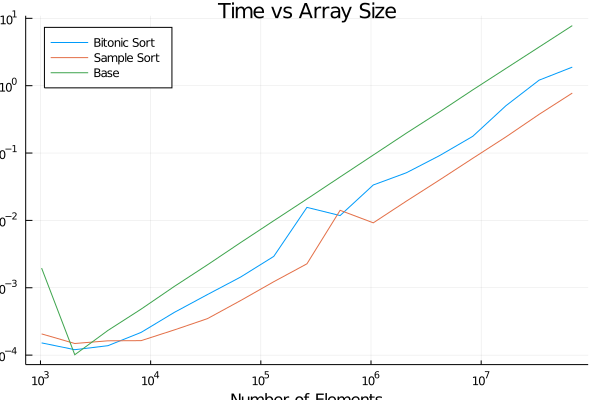

In [3]:
sizes = [2 .^ i for i = 6:20]

scale = 1e-6

tau = 1e-4
mu = 1e-7

function runtime_bitonic(n, p, tau, mu)
    ratio = n/p
    comp_time = (ratio)*log(ratio) + ratio * log(p).^2
    comm_time = tau * log(p).^2 + mu * ratio * log(p).^2
   return comp_time + comm_time
end


function mergesort_runtime(n)
    return n * log(n)
end

function sample_runtime(n,p, tau, mu)
    ratio = n / p
    comp_time = (n*log(n) / p) + p * (log(p)).^2
    comm_time = tau * p + mu *(ratio + p * log(p).^2)
   return comp_time + comm_time
end

plt = plot(sizes, runtime_bitonic.(sizes, 16, tau, mu) .* scale, labels="Bitonic", yaxis=:log, xaxis=:log, title="Runtime Complexity")
plot!(sizes, sample_runtime.(sizes, 16, tau, mu) .* scale, labels="Sample Sort")
plot!(sizes, mergesort_runtime.(sizes) .* scale, labels="Mergesort", legend=:topleft)


png(plt, "ideal_runtime")
display(plt)

LoadError: could not load library "libopenlibm"
The specified module could not be found. 

When comparing keys sorted per second vs array size, we can see that the both Bitonic and Sample sort are faster than the serial sorting algorithm. It can be noted that as the number of elements increases, the serial sorting algorithm decreases in rate of Keys per Second indicating that the algorithm is not well suited for large arrays. On the contrary, Keys per Second stays mostly constant for both Bitonic and Sample sort as the size of the array increases. Also, the sharp change in rate for both Bitonic and Sample occurs due to the change in communication protocol to be more efficient with larger array sizes.
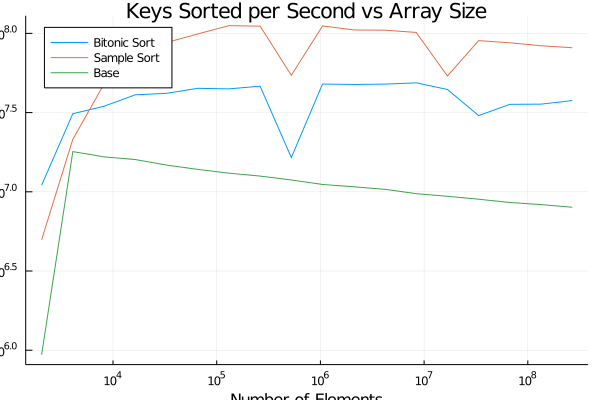

We also want to examine how sorting and already sorted arrays change the runtime of these algorithms. For both bitonic sort and sample sort, we found that sorting the global array beforehand increased performace.
For bitonic sort, sorting the array beforehand meant that merge operations contained fewer comparisons than for a non-sorted array. So while the same amount of data is sent via the network for a sorted array, the work per processor slightly decreased.  

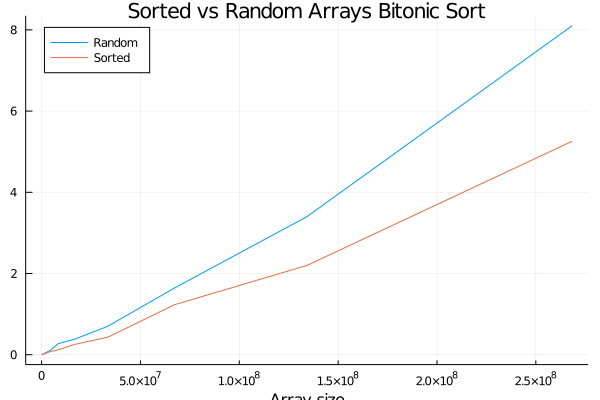

For sample sort, sorting the array decreases the time taken by sample sort by more than half. When the array is already sorted, the algorithm does not need to send large amounts of data to other processors. While it still must communicate its spliters to other processors, elements of the array being sorted will not need to be sent to other processors because they are already in the correct "bucket".

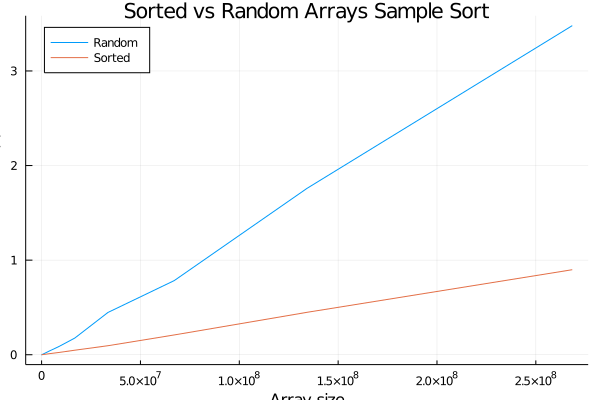
